In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer, sent_tokenize, word_tokenize
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshaybhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akshaybhat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshaybhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/akshaybhat/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
data = pd.read_csv('questions.csv') # data has 400k rows

In [4]:
data = data[:50000] # taking it to 50k rows for the proto-type as well as for the memory error issue

In [5]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
len(data)

50000

In [7]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
data = data.dropna()

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

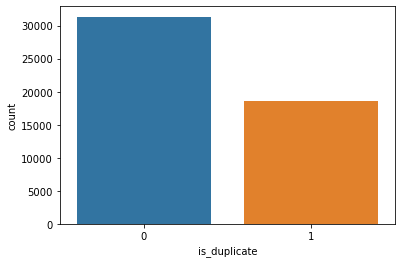

In [9]:
sns.countplot(data['is_duplicate'])

In [10]:
data['is_duplicate'].value_counts()

0    31350
1    18650
Name: is_duplicate, dtype: int64

In [11]:
#percentage of duplicate and non-duplicate values
print('The percentage of duplicated to non-duplicated: ')
(data['is_duplicate'].value_counts() / data['is_duplicate'].count()* 100)

The percentage of duplicated to non-duplicated: 


0    62.7
1    37.3
Name: is_duplicate, dtype: float64

**The data is imbalanced**

# Text Preprocessing & Feature Engineering

In [12]:
def text_preprocess(text):

    # lowercase and strip the text
    text = str(text).lower().strip()

    # remove all the html tags
    def remove_html_tags(text):
        tags_removed = re.compile(r'<.*?>')
        return tags_removed.sub(r'', text)
    text = remove_html_tags(text)

    # replace certain parameters
    def replace_things(text):
        text = text.replace('$', ' dollars ')
        text = text.replace('%', ' percent ')
        text = text.replace('-', '')
        text = text.replace('₹', ' rupees ')
        text = text.replace('€', ' euros ')
        text = text.replace('£', ' ponds ')
        text = re.sub(r'([0-9]+)000000000', r'\1b', text)
        text = re.sub(r'([0-9]+)000000', r'\1m', text)
        text = re.sub(r'([0-9]+)000', r'\1k', text)
        text = re.sub(r'([0-9]+),000,000,000', r'\1b', text)
        text = re.sub(r'([0-9]+),000,000', r'\1m', text)
        text = re.sub(r'([0-9]+),000', r'\1k', text)
        return text
    text = replace_things(text)

    # stopwords removal
    def remove_stopwords(text):
        new_corpus = []
        for word in text.split():
            if word in stopwords.words('english'):
                new_corpus.append('')
            else:
                new_corpus.append(word)
        corpus = new_corpus[:]
        new_corpus.clear()
        return ' '.join(corpus)
    text = remove_stopwords(text)

    # tokenization
    def tokenization(text):
        #lets try with sentence tokenization
        # words = sent_tokenize(text)
        # lets try with word tokenization
        new = word_tokenize(text)
        return ' '.join(new)
    text = tokenization(text)

    # stemming / lemmatization
    def stemming_process(text):
        ps = PorterStemmer()
        ws = WordNetLemmatizer()
        stem = [ws.lemmatize(word) for word in text]
        return ''.join(stem)
    text = stemming_process(text)

    # remove puncuations
    def remove_punctuation(text):
        exclude = string.punctuation
        return text.translate(str.maketrans('','',exclude))
    text = remove_punctuation(text)

    return text.strip()

In [13]:
sentence = 'I AM AKSHAY BHAT <kskksk/.> and 100,000$ training the most beautiful'
text_preprocess(sentence)

'akshay bhat 100k dollars training beautiful'

In [14]:
# apply it on the dataset
data['question1'] = data['question1'].apply(text_preprocess)
data['question2'] = data['question2'].apply(text_preprocess)

In [15]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve it,find remainder math 23 24 math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane...,fish would survive salt water,0


In [16]:
# data for further modelling
data_for_modelling = data[['question1', 'question2', 'is_duplicate']]

In [17]:
data_for_modelling

,question1,question2,is_duplicate
0,step step guide invest share market india,step step guide invest share market,0
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,mentally lonely solve it,find remainder math 23 24 math divided 2423,0
4,one dissolve water quikly sugar salt methane...,fish would survive salt water,0
...,...,...,...
49995,become succesful electrical maintenance engineer,best way good maintenance electrical engineer,1
49996,aside essays differences business school appl...,aside essays differences business school appl...,0
49997,kill procrastination,what s efficient way overcome procrastination,0
49998,control anger towards friends,control anger towards family,0


In [18]:
# feature engineering part

#total length
data_for_modelling['q1_count'] = data_for_modelling['question1'].str.len()
data_for_modelling['q2_count'] = data_for_modelling['question2'].str.len()

# word count
data_for_modelling['q1_word_count'] = data_for_modelling['question1'].map(lambda x: len(x.split(' ')))
data_for_modelling['q2_word_count'] = data_for_modelling['question2'].map(lambda x: len(x.split(' ')))

# common words
def common_words(row):
    w1 = set(map(lambda x: x.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda x: x.lower().strip(), row['question2'].split(' ')))
    return len(w1 & w2)

# total words
def total_words(row):
    w1 = set(map(lambda x: x.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda x: x.lower().strip(), row['question2'].split(' ')))
    return (len(w1) + len(w2))

# common word ratio
def common_words_ratio(row):
    common = row['common_words'] / row['total_words']
    return common



data_for_modelling['common_words'] = data_for_modelling.apply(common_words, axis=1)
data_for_modelling['total_words'] = data_for_modelling.apply(total_words, axis = 1)
data_for_modelling['common_word_ratio'] = data_for_modelling.apply(common_words_ratio, axis = 1)

<ipython-input-18-ae45c5c2ea40>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_modelling['q1_count'] = data_for_modelling['question1'].str.len()
<ipython-input-18-ae45c5c2ea40>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_modelling['q2_count'] = data_for_modelling['question2'].str.len()


In [19]:
data_for_modelling

,question1,question2,is_duplicate,q1_count,q2_count,q1_word_count,q2_word_count,common_words,total_words,common_word_ratio
0,step step guide invest share market india,step step guide invest share market,0,41,35,7,6,5,11,0.454545
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,33,69,6,11,3,13,0.230769
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,44,36,6,5,2,11,0.181818
3,mentally lonely solve it,find remainder math 23 24 math divided 2423,0,25,49,5,14,1,13,0.076923
4,one dissolve water quikly sugar salt methane...,fish would survive salt water,0,62,29,12,5,2,16,0.125000
...,...,...,...,...,...,...,...,...,...,...
49995,become succesful electrical maintenance engineer,best way good maintenance electrical engineer,1,48,45,5,6,3,11,0.272727
49996,aside essays differences business school appl...,aside essays differences business school appl...,0,79,84,12,14,11,23,0.478261
49997,kill procrastination,what s efficient way overcome procrastination,0,20,45,2,6,1,8,0.125000
49998,control anger towards friends,control anger towards family,0,29,28,4,4,3,8,0.375000


# Text Representation

In [20]:
# using_tfidf
tf_idf = TfidfVectorizer(max_features=6000)

In [21]:
df = data_for_modelling.copy() # keeping a copy for the future use

In [22]:
# adding all those questions into a list
questions = list(data_for_modelling['question1']) + list(data_for_modelling['question2'])

# fitting tf-idf 
q1_array, q2_array = np.vsplit(tf_idf.fit_transform(questions).toarray(), 2)

In [23]:
q1_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
q2_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
temp_1 = pd.DataFrame(q1_array, 
                      index=data_for_modelling.index)
temp_2 = pd.DataFrame(q2_array,
                      index = data_for_modelling.index)
preprocessed_data = pd.concat([temp_1,temp_2], axis = 1)

In [ ]:
preprocessed_data

In [ ]:
data_for_modelling.columns

In [ ]:
data_for_modelling = data_for_modelling[['q1_count', 'q2_count',
       'q1_word_count', 'q2_word_count', 'common_words', 'total_words',
       'common_word_ratio','is_duplicate']]

In [ ]:
data_for_modelling

In [ ]:
data_preprocessed = pd.concat([preprocessed_data, data_for_modelling], axis = 1)

In [ ]:
data_preprocessed

In [ ]:
X = data_preprocessed.iloc[:,:-1].values
y = data_preprocessed.iloc[:,-1].values

In [ ]:
X

In [ ]:
X.shape

In [ ]:
y

In [ ]:
# data splitting for model building
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.26, random_state = 32)

# Model Building

In [ ]:
# RandomForest Model
RF = RandomForestClassifier(criterion='entropy',
                            random_state=32)
RF.fit(X_train, y_train)

In [ ]:
y_pred_rf = RF.predict(X_test)

# Model Evaluation

In [ ]:
print('The accuracy score for RandomForest Model is: {} %'.format(round(accuracy_score(y_test, y_pred_rf)* 100,2)))

In [ ]:
confusion_matrix(y_test, y_pred_rf)

# Model Testing

In [ ]:
# 7 features

# let's define a function to take two input quries
def common_words(q1,q2):
    w1 = set(map(lambda x: x.lower().strip(), q1.split(' ')))
    w2 = set(map(lambda x: x.lower().strip(), q2.split(' ')))
    return len(w1 & w2)

# total words
def total_words(q1, q2):
    w1 = set(map(lambda x: x.lower().strip(), q1.split(' ')))
    w2 = set(map(lambda x: x.lower().strip(), q2.split(' ')))
    return (len(w1) + len(w2))



In [ ]:
def find_patterns_for_text(q1,q2):

    query = [] # empty list

    q1 = text_preprocess(q1) # applying text preprocessing
    q2 = text_preprocess(q2) # applying text preprocessing

    #append the features
    query.append(len(q1))
    query.append(len(q2))

    # fetching word count
    query.append(len(q1.split(' ')))
    query.append(len(q2.split(' ')))

    # fetching common words
    query.append(common_words(q1,q2))

    # fetching total words
    query.append(total_words(q1,q2))

    # fetching common word ratio
    query.append(total_words(q1,q2) / common_words(q1,q2))

    # apply tf-idf
    q1_tfidf = tf_idf.transform([q1]).toarray()
    q2_tfidf = tf_idf.transform([q2]).toarray()

    return np.hstack((np.array(query).reshape(1,7), q1_tfidf,q2_tfidf))

In [ ]:
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'
q1 = 'Where is the capital of India?'

In [ ]:
RF.predict(find_patterns_for_text(q1,q3)) 

In [ ]:
import pickle
pickle.dump(RF, open('random_forest_model_for_quora_duplicate.pkl', 'wb'))
pickle.dump(tf_idf, open('tf-idf_text_representation.pkl', 'wb'))